In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import sklearn.linear_model

In [2]:
df = pd.read_csv("../final_projects/assets/ufo_reports.csv", sep='\t')
df=df[(~df.Long.isnull()) & (~df.Lat.isnull())]
df.columns
df.shape

(12172, 30)

In [3]:
from datetime import datetime
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

In [4]:
features = ['Date','Time','Lat', 'Long', 'City', 'State', 'Summary']
data = pd.DataFrame(df, columns=features)
data['Diff'] = data['Date'].apply(lambda x: days_between(str(x), '2014-01-01'))
data.head(2)

,Date,Time,Lat,Long,City,State,Summary,Diff
0,2015-12-31,23:59,44.052069,-123.086746,Eugene,OR,Viewed 4 slow moving orange-ish orbs on new ye...,729
1,2015-12-31,15:00,44.848449,-123.233987,Monmouth,OR,A white balloon gives off a bright blue light ...,729


In [5]:
## Combine date and time
import datetime
time= [r.split(':') for r in data['Time']]
day = [r.split('-') for r in data['Date']]

In [6]:
dt = []
for i in range(0,len(time)):
    try:
        dt.append(datetime.datetime.combine(datetime.date(int(day[i][0]), int(day[i][1]), int(day[i][2])), datetime.time(int(time[i][0]), int(time[i][1]))))
    except ValueError:
        dt.append(None)
                       
data['Date']=dt

In [7]:
data.head()

,Date,Time,Lat,Long,City,State,Summary,Diff
0,2015-12-31 23:59:00,23:59,44.052069,-123.086746,Eugene,OR,Viewed 4 slow moving orange-ish orbs on new ye...,729
1,2015-12-31 15:00:00,15:00,44.848449,-123.233987,Monmouth,OR,A white balloon gives off a bright blue light ...,729
2,2015-12-30 22:00:00,22:00,45.523447,-122.676207,Portland,OR,Dozen red green blue lights in portland sky th...,728
3,2015-12-30 19:30:00,19:30,44.046237,-123.022028,Springfield,OR,"Shape changing UFO's in Springfield, Oregon.",728
4,2015-12-30 16:50:00,16:50,45.467337,-122.352587,Orient,OR,"While driving at sunset I saw a hovering, vert...",728


### - Taking the $\pm$ n days of the event 

#### eg. Navy Misslie: 11-07-2015, n=3

In [10]:
data_event = data[(data.Diff > 671) & (data.Diff < 679)]
data_event.shape

(403, 8)

###  - NLP : Computing the similarity between summary

In [11]:
from gensim.models import Word2Vec
# Setup the body text
text = data_event.Summary.str.lower()

In [12]:
import nltk, string
from sklearn.feature_extraction.text import TfidfVectorizer


stemmer = nltk.stem.porter.PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

'''remove punctuation, lowercase, stem'''
def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.lower().translate(remove_punctuation_map)))

vectorizer = TfidfVectorizer(tokenizer=normalize, stop_words='english')

def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]

In [13]:
def summary_scores():
    '''
    Returns the reference text from the event. 
    
    '''
    score_map = {}
    
    for i in range(1, len(data_event)):
        score_map[i] = 0
        for j in range(i+1, len(data_event)):
            score_map[j] = 0
            if cosine_sim(text.iloc[i], text.iloc[j]) > 0.5:
                score_map[i] += 1
                score_map[j] += 1
    return score_map
    
    # look for that value from score_map.values() which is maximum
#print 'best summary:', max(score_map.items(), key=lambda x: x[1])    
sim_score = summary_scores()

In [14]:
print 'best summary:', max(sim_score.items(), key = lambda x: x[1])

best summary: (51, 106)


In [16]:
sim = []
for i in range(0,len(text)):
    try:
        sim.append(cosine_sim(text.iloc[i],text.iloc[51]))
    except ValueError:
        sim.append(0);
data_event['Sim'] = sim   

data_event.head()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Date,Time,Lat,Long,City,State,Summary,Diff,Sim
24,2015-11-07 19:00:00,19:00,44.939008,-123.060927,West Salem,OR,A white ball shaped light moving at a super hi...,675,0.490834
396,2015-11-08 18:30:00,18:30,37.822758,-112.435759,Panguitch,UT,Red light in sky. It seemed as it turned there...,676,0.129283
397,2015-11-07 19:30:00,19:30,40.299397,-109.988759,Roosevelt,UT,Large light in the sky with smoke. ((NUFORC N...,675,0.716812
398,2015-11-07 19:02:00,19:02,40.343286,-111.720759,Lindon,UT,"The light looked like a giant spot light, but ...",675,0.472132
399,2015-11-07 19:00:00,19:00,40.314120,-112.006880,Eagle Mountain,UT,4 Witnesses see U.F.O in Eagle Mountain. ((N...,675,0.474493


In [17]:
print text.iloc[51]

bright white light in the sky.  ((nuforc note:  u. s. navy missile launch.  pd))


### - K - Means for Location

In [18]:
from sklearn import cluster
cls = cluster.k_means(data_event[['Lat', 'Long']].values,4)
data_event['Cluster']= cls[1]
data_event.head()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Date,Time,Lat,Long,City,State,Summary,Diff,Sim,Cluster
24,2015-11-07 19:00:00,19:00,44.939008,-123.060927,West Salem,OR,A white ball shaped light moving at a super hi...,675,0.490834,1
396,2015-11-08 18:30:00,18:30,37.822758,-112.435759,Panguitch,UT,Red light in sky. It seemed as it turned there...,676,0.129283,1
397,2015-11-07 19:30:00,19:30,40.299397,-109.988759,Roosevelt,UT,Large light in the sky with smoke. ((NUFORC N...,675,0.716812,1
398,2015-11-07 19:02:00,19:02,40.343286,-111.720759,Lindon,UT,"The light looked like a giant spot light, but ...",675,0.472132,1
399,2015-11-07 19:00:00,19:00,40.314120,-112.006880,Eagle Mountain,UT,4 Witnesses see U.F.O in Eagle Mountain. ((N...,675,0.474493,1


Here I divided all the locations to 4 clusters. Question: What is a best number for the clusters?

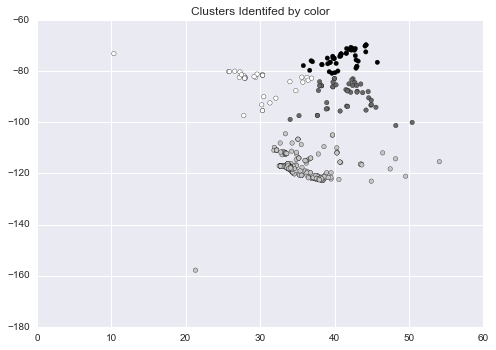

In [19]:
plt.scatter(data_event.Lat.values, data_event.Long.values, c=list(data_event.Cluster.values))
plt.title('Clusters Identifed by color')
plt.show()

In [45]:
data_region0 = data_event[(data_event.Cluster == 0) & (data_event.Sim > 0.5)]
print data_region0.shape

data_region1 = data_event[(data_event.Cluster == 1) & (data_event.Sim > 0.5)]
print data_region1.shape

data_region2 = data_event[(data_event.Cluster == 2) & (data_event.Sim > 0.5)]
print data_region2.shape

data_region3 = data_event[(data_event.Cluster == 3) & (data_event.Sim > 0.5)]
print data_region3.shape


(117, 10)
(0, 10)
(0, 10)
(1, 10)


### - Time Series Analysis

In [47]:
data_time = pd.DataFrame(data_region0)
data_time.set_index('Date',inplace=True)
data_time.index = pd.to_datetime(data_time.index, unit='s')
data_time.head()

,Time,Lat,Long,City,State,Summary,Diff,Sim,Cluster
Date,,,,,,,,,
2015-11-07 19:30:00,19:30,40.299397,-109.988759,Roosevelt,UT,Large light in the sky with smoke. ((NUFORC N...,675,0.716812,0
2015-11-07 19:00:00,19:00,40.314120,-112.006880,Eagle Mountain,UT,"Unnatural bright light emitted from the sky, i...",675,0.668348,0
2015-11-07 19:00:00,19:00,38.573319,-109.549837,Moab,UT,Bright light in the sky with corresponding dus...,675,0.742260,0
2015-11-07 19:40:00,19:40,36.747727,-119.772367,Fresno,CA,object spraying a substance and had blue light...,675,0.566644,0
2015-11-07 19:00:00,19:00,37.287167,-121.949958,Campbell,CA,"Cone of light, bright blue contrail and symmet...",675,0.572739,0


In [50]:
data_time_count = data_time[['Time']].resample('5Min', how='count')
data_time_count['Lat'] = data_time[['Lat']] .resample('5Min', how='mean')
data_time_count['Long'] = data_time[['Long']] .resample('5Min', how='mean')
data_time_count=data_time_count.dropna()
data_time_count.head()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  from ipykernel import kernelapp as app
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  app.launch_new_instance()


,Time,Lat,Long
Date,,,
2015-11-06 20:00:00,1,34.869738,-111.760986
2015-11-07 18:00:00,40,35.453902,-118.688488
2015-11-07 18:05:00,13,35.199857,-118.698946
2015-11-07 18:10:00,9,34.745674,-118.108964
2015-11-07 18:15:00,7,35.389401,-118.797150


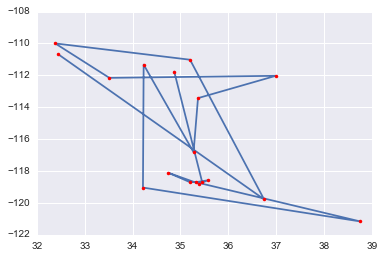

In [51]:
plt.plot(data_time_count['Lat'], data_time_count['Long'])
plt.plot(data_time_count['Lat'], data_time_count['Long'], '.', color='red')

In [20]:
x = data_time_count['Lat']
y = data_time_count['Long']

plt.figure()
for i in range(0,len(data_time_count)-1):
    plt.quiver(x[i], y[i], x[i+1]-x[i], y[i+1]-y[i], scale_units = 'xy', angles='xy', scale=1)

plt.plot(data_time_count['Lat'], data_time_count['Long'], '.', color='red')
plt.show()
plt.plot(x[0], y[0], color='blue')

NameError: name 'data_time_count' is not defined